In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import math
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from multiproc import compute_correlations
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

In [5]:
# session = 'Mary-Anesthesia-20160912-02'
# session = 'Mary-Anesthesia-20160809-01'
session = 'MrJones-Anesthesia-20160105-01'

# Load Neural Data 

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Load VAR Results

In [6]:
VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)

In [154]:
timescales = VAR_results['all'].eigs.apply(lambda eigs: 0.001/np.abs(np.log(np.max(np.abs(eigs)))))

In [34]:
timescales_wake = timescales[VAR_results['all'].start_time <= session_info['drugStart'][0]]

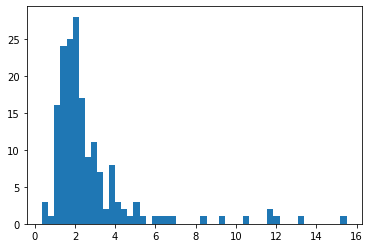

In [37]:
plt.hist(timescales_wake[timescales_wake <= 20],bins=50)
plt.show()

In [38]:
eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [39]:
timescales_anesthesia = timescales[np.logical_and(VAR_resul ts['all'].start_time >= eyes_close, VAR_results['all'].start_time <= session_info['drugEnd'][1])]

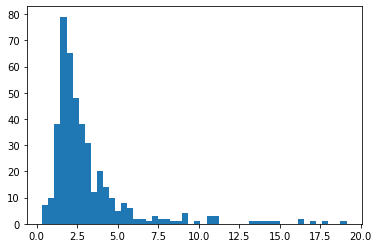

In [40]:
plt.hist(timescales_anesthesia[timescales_anesthesia <= 20],bins=50)
plt.show()

In [13]:
timescales.min()

0.34078013016001224

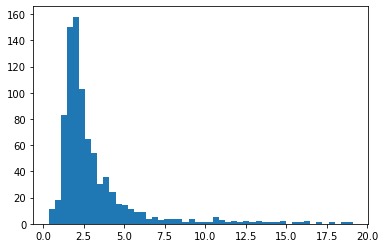

In [27]:
plt.hist(timescales[timescales <= 20], bins=50)
plt.show()

## Persistence Baseline

In [8]:
persistence_baseline = {}
iterator = tqdm(total = len(VAR_results.keys())*len(window_selection_info['true_vals']['all'].keys()))
for area in VAR_results.keys():
    if area == 'all':
        area_indices = np.arange(len(electrode_info['area']))
    else:
        area_indices = np.where(electrode_info['area'] == area)[0]
    persistence_baseline[area] = {}
    for window in window_selection_info['true_vals'][area].keys():
        persistence_baseline[area][window] = np.zeros(window_selection_info['step_mse'][area][window].shape)
        for i in range(persistence_baseline[area][window].shape[0]):
#             xt_plus_1= lfp[(i+1)*int(window/dt) + 1:(i+1)*int(window/dt) + persistence_baseline[area][window].shape[1] + 1, area_indices]
            xt = lfp[(i+1)*int(window/dt):(i+1)*int(window/dt) + persistence_baseline[area][window].shape[1], area_indices]
            xt_minus_1 = lfp[(i+1)*int(window/dt) - 1:(i+1)*int(window/dt) + persistence_baseline[area][window].shape[1] - 1, area_indices]
            persistence_baseline[area][window][i] = ((xt - xt_minus_1)**2).mean(axis=1)
        
        iterator.update()
iterator.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
        
slice_funcs = dict(
    pre=lambda window: slice(0, int(session_info['drugStart'][0]/window)),
    induction=lambda window: slice(int(session_info['drugStart'][0]/window), int(eyes_close/window)),
    during=lambda window: slice(int(eyes_close/window), int(session_info['drugEnd'][1]/window)),
    post=lambda window: slice(int(session_info['drugEnd'][1]/window),-1)
)

In [10]:
area_colors = {'vlPFC': 'C0', 'FEF': 'skyblue', '7b': 'slategray', 'CPB': 
               'lightsteelblue', 'all': 'darkviolet'}

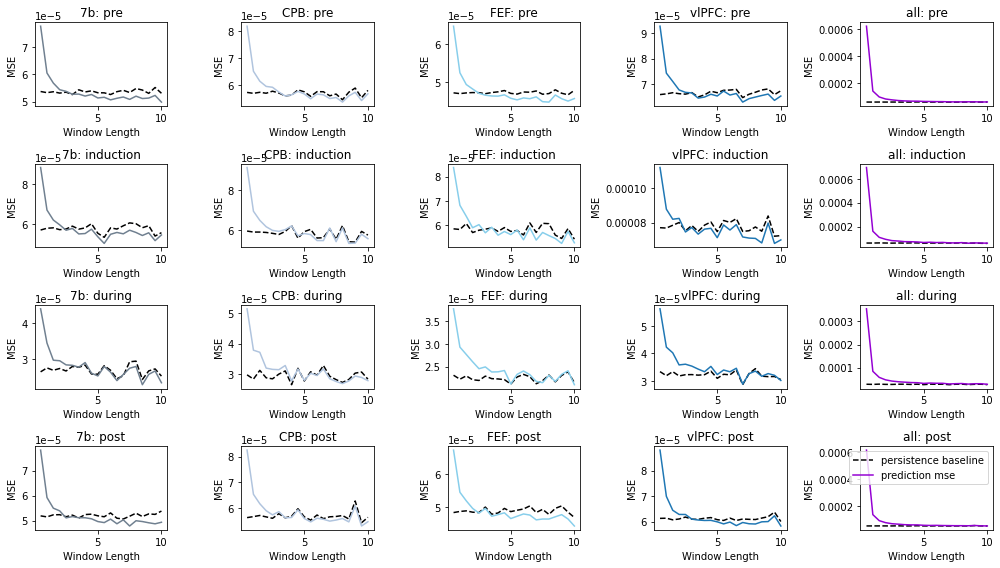

In [11]:
fig, axs = plt.subplots(4, 5, figsize=(14, 8))

for i, key in enumerate(['pre', 'induction', 'during', 'post']):
    for j, area in enumerate(persistence_baseline.keys()):
        ax = axs[int((i*5 + j)/5)][(i*5 + j) % 5]
        pbs = []
        mses = []
        windows = np.arange(1, 21)*0.5
        for window in persistence_baseline[area].keys():
            pbs.append(persistence_baseline[area][window].mean(axis=1)[slice_funcs[key](window)].mean())
            mses.append(window_selection_info['step_mse'][area][window].mean(axis=1)[slice_funcs[key](window)].mean())
        ax.plot(windows, pbs, label='persistence baseline', c='k', linestyle='--')
        ax.plot(windows, mses, label='prediction mse', c=area_colors[area])
        ax.set_xlabel('Window Length')
        ax.set_ylabel('MSE')
        ax.set_title(f'{area}: {key}')
ax.legend()
plt.tight_layout()
plt.show()

# Data Shuffling

In [7]:
row = VAR_results['all'].iloc[np.argmax(VAR_results['all'].start_time >= session_info['drugStart'][1]) + 20]

NameError: name 'session_info' is not defined

In [ ]:
window_data = lfp[row.start_ind:row.end_ind]

In [ ]:
ind = 1
window_data[shuffled_inds][ind] - window_data[shuffled_inds[ind]]

In [ ]:
# shuffled_inds = np.random.choice(np.arange(window_data.shape[0]), size=(window_data.shape[0]), replace=False)
# window_data_shuffled = window_data[shuffled_inds]
window_data_shuffled = np.repeat((np.random.normal(size=(window_data.shape[1]))*window_data.std() + window_data.mean())[:, np.newaxis], window_data.shape[0], axis=1).T
window_data_shuffled = window_data_shuffled + np.random.normal(size=(window_data_shuffled.shape))*(window_data.std()/100)

In [ ]:
from multiproc import compute_VAR

In [ ]:
ret = compute_VAR(window_data)
ret_shuffled = compute_VAR(window_data_shuffled)

In [ ]:
plt.plot(window_data_shuffled[:,0], label='random noise unit 0')
plt.plot(window_dat_shuffled[:, 1], label='random noise unit 1')
plt.show()

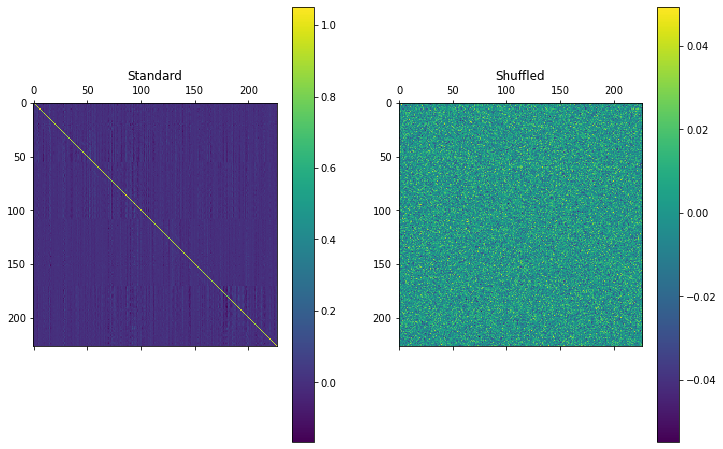

In [94]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.matshow(ret['A_mat'], fignum=False)
plt.colorbar()
plt.title('Standard')

plt.subplot(1, 2, 2)
plt.matshow(ret_shuffled['A_mat'], fignum=False)
plt.colorbar()
plt.title('Shuffled')

plt.show()

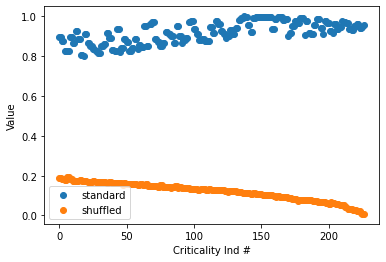

In [95]:
plt.scatter(np.arange(len(ret['criticality_inds'])), ret['criticality_inds'], label='standard')
plt.scatter(np.arange(len(ret_shuffled['criticality_inds'])), ret_shuffled['criticality_inds'], label='shuffled')
plt.xlabel('Criticality Ind #')
plt.ylabel('Value')
plt.legend()
plt.show()

# What about bandpass filtering?

In [43]:
pred_steps=250
pct_of_value=0.95
# bandpass_info={'flag': True, 'low': 0.5, 'high': 100}
bandpass_info={'flag': False, 'low': 0.5, 'high': 100}
return_data=True
verbose=True

In [44]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:

all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

results_dir = os.path.join(f'/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR')

# -----------------------------------------------------
# check if session has already computed VAR_results with selected windows
# (note that this does not check if more windows have been added since the last computation)
# -----------------------------------------------------
window_selection_dir = os.path.join(results_dir, 'window_selection')
os.makedirs(window_selection_dir, exist_ok=True)

if bandpass_info is None:
    regex = re.compile(f"VAR_{session}_selected_windows_phases_{pred_steps}_steps")
else:
    if bandpass_info['flag']:
        regex = re.compile(f"VAR_{session}_selected_windows_bandpass_phases_{pred_steps}_steps")
    else:
        regex = re.compile(f"VAR_{session}_selected_windows_phases_{pred_steps}_steps")

VAR_results_path = None
for file_name in os.listdir(window_selection_dir):
    if regex.match(file_name):
        VAR_results_path = os.path.join(window_selection_dir, file_name)
        if verbose:
            print(f"VAR results with selected windows found for session {session}.")
        break

# -----------------------------------------------------
# check if session has already computed selected windows
# (note that this does not check if more windows have been added since the last computation)
# -----------------------------------------------------
if bandpass_info is None:
    regex = re.compile(f"{session}_selected_windows_phases_{pred_steps}_steps")
else:
    if bandpass_info['flag']:
        regex = re.compile(f"{session}_selected_windows_bandpass_phases_{pred_steps}_steps")
    else:
        regex = re.compile(f"{session}_selected_windows_phases_{pred_steps}_steps")


window_selection_info_path = None
for file_name in os.listdir(window_selection_dir):
    if regex.match(file_name):
        window_selection_info_path = os.path.join(window_selection_dir, file_name)
        if verbose:
            print(f"Window selection info found for session {session}.")
        break

else: # ONLY RUNS THIS IF VAR RESULTS NOT FOUND:

    # -----------------------------------------------------
    # make slice function
    # -----------------------------------------------------
    filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
    session_info = loadmat(filename, variables=['sessionInfo'], verbose=False)
    if data_class == 'propofolPuffTone':
        eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
        # slice_funcs = dict(
        #     pre=lambda window: slice(0, int(session_info['drugStart'][0]/window)),
        #     during=lambda window: slice(int(session_info['drugStart'][0]/window), int(session_info['drugEnd'][1]/window)),
        #     post=lambda window: slice(int(session_info['drugEnd'][1]/window),-1)
        # )
        slice_funcs = dict(
            pre=lambda window: slice(0, int(session_info['drugStart'][0]/window)),
            induction=lambda window: slice(int(session_info['drugStart'][0]/window), int(eyes_close/window)),
            during=lambda window: slice(int(eyes_close/window), int(session_info['drugEnd'][1]/window)),
            post=lambda window: slice(int(session_info['drugEnd'][1]/window),-1)
        )
    elif data_class == 'leverOddball':
        slice_funcs = dict(
            whole=lambda window: slice(0, -1)
        )
    # -----------------------------------------------------
    # RUN WINDOW SELECTION
    # -----------------------------------------------------
    if window_selection_info_path is None:
        if verbose:
            print(f"Session {session}: selected windows by phase with {pred_steps}-step prediction not found. Running now.")

#         variables = ['electrodeInfo', 'lfp', 'lfpSchema']
#         session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=verbose)
#         electrode_info, lfp, lfp_schema = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema']
       
#         lfp = butter_bandpass_filter(lfp, bandpass_info['low'], bandpass_info['high'], 1/dt)
    
        # find completed windows 
        # TODO: account for the specific bandpass frequencies
        windows = []
        if bandpass_info is None:
            regex = re.compile(f"VAR_{session}_window_" + ".{1,3}_stride_.{1,3}_[a-zA-Z]{3}-")
        else:
            if bandpass_info['flag']:
                regex = re.compile(f"VAR_{session}_window_" + ".{1,3}_stride_.{1,3}_bandpass")
            else:
                regex = re.compile(f"VAR_{session}_window_" + ".{1,3}_stride_.{1,3}_[a-zA-Z]{3}-")

        for file_name in os.listdir(results_dir):
            if regex.match(file_name):
                if bandpass_info is None:
                    windows.append(float(file_name.split('_')[-3]))
                else:
                    if bandpass_info['flag']:
                        windows.append(float(file_name.split('_')[-7]))
                    else:
                        windows.append(float(file_name.split('_')[-3]))
        windows.sort()
        windows = [int(w) if w % 1 == 0 else w for w in np.unique(windows)]

        # -----------------------------------------------------
        # compute forward predictions
        # (note that this assumes window and stride are the same)
        # -----------------------------------------------------

        T_pred = pred_steps

        predictions = {}
        true_vals = {}
        step_mse = {}
        for area in np.unique(electrode_info['area']):
            predictions[area] = {}
            true_vals[area] = {}
            step_mse[area] = {}
        predictions['all'] = {}
        true_vals['all'] = {}
        step_mse['all'] = {}

        for window in windows:
            stride = window
            if verbose:
                print(f"Now computing window = {window}")
            VAR_results_dir = get_result_path(results_dir, session, window, stride, bandpass_info=bandpass_info)
            VAR_results = {}
            for file_name in tqdm(os.listdir(VAR_results_dir)):
                try:
                    VAR_results[file_name] = load(os.path.join(VAR_results_dir, file_name))
                except IsADirectoryError:
                    if verbose:
                        print(f"Need to compile {os.path.join(VAR_results_dir, file_name)}")
                    # compile results
                    VAR_results[file_name] = compile_folder(os.path.join(VAR_results_dir, file_name))

            for area in VAR_results.keys():
                if area == 'all':
                    unit_indices = np.arange(len(electrode_info['area']))
                else:
                    unit_indices = np.where(electrode_info['area'] == area)[0]

                predictions[area][window] = np.zeros((len(VAR_results[area]) - 1, T_pred, len(unit_indices)))
                true_vals[area][window] = np.zeros(predictions[area][window].shape)

                for i in tqdm(range(predictions[area][window].shape[0])):
                    row = VAR_results[area].iloc[i]
                    start_step = int(stride*i/dt)
                    # x0 = lfp[start_step + int(window/dt) - 1, unit_indices]

                    for t in range(T_pred):
                        predictions[area][window][i, t] = np.hstack([[1], lfp[start_step + int(window/dt) - 1 + t, unit_indices]]) @ row.A_mat_with_bias
                        # if t == 0:
                        #     predictions[area][window][i, t] = np.hstack([[1], x0]) @ row.A_mat_with_bias
                        # else:
                        #     predictions[area][window][i, t] = np.hstack([[1], predictions[area][window][i, t - 1]]) @ row.A_mat_with_bias

                    true_vals[area][window][i] = lfp[start_step + int(window/dt):start_step + int(window/dt) + T_pred, unit_indices]

                step_mse[area][window] = ((predictions[area][window] - true_vals[area][window])**2).mean(axis=2)

        # -----------------------------------------------------
        # pick and save selected_windows
        # -----------------------------------------------------
        selected_windows = {}
        window_mses = {}

        phases = slice_funcs.keys()

        for phase in phases:
            slice_func = slice_funcs[phase]
            selected_windows[phase] = {}
            window_mses[phase] = {}
            for area in step_mse.keys():
                window_mses[phase][area] = [step_mse[area][window][slice_func(window), :].mean() for window in windows]

                asymptotic_value = np.array(window_mses[phase][area]).min()
                asymptotic_ind = np.argmin(window_mses[phase][area])
                for i in range(len(window_mses[phase][area])):
                    if window_mses[phase][area][i]*pct_of_value <= asymptotic_value or i == asymptotic_ind:
                        selected_windows[phase][area] = windows[i]
                        break

        window_selection_info = dict(
            selected_windows=selected_windows,
            predictions=predictions,
            true_vals=true_vals,
            step_mse=step_mse,
            window_mses=window_mses
        )

        save_file_path = os.path.join(window_selection_dir, f"{session}_selected_windows_phases_{pred_steps}_steps")
        if bandpass_info is not None:
            if bandpass_info['flag']:
                save_file_path = os.path.join(window_selection_dir, f"{session}_selected_windows_bandpass_phases_{pred_steps}_steps")
#             save(window_selection_info, save_file_path)
    else:
        window_selection_info = load(window_selection_info_path)

    # -----------------------------------------------------
    # LOAD AND COMPILE DATA
    # -----------------------------------------------------

    selected_windows = window_selection_info['selected_windows']

    window_info = {}
    for phase in selected_windows.keys():
        for area, window in selected_windows[phase].items():
            window = int(window) if window % 1 == 0 else window
            if window not in window_info.keys():
                window_info[window] = []
            window_info[window].append((area, phase))

    columns = ['explained_variance', 'A_mat', 'A_mat_with_bias', 'eigs',
                'criticality_inds', 'sigma2_ML', 'AIC', 'sigma_norm', 'start_time',
                    'start_ind', 'end_time', 'end_ind']

    VAR_results = {}
    key = list(selected_windows.keys())[0]
    for area in selected_windows[key].keys():
        VAR_results[area] = {col: [] for col in columns}


    for window in window_info.keys():
        stride = window
        areas_to_load = np.unique([entry[0] for entry in window_info[window]])
        VAR_results_dir = get_result_path(results_dir, session, window, stride)

        temp_results = {}
        for area in areas_to_load:
            if verbose:
                print(f"Now attempting to load area {area} with window {window}")
            try:
                temp_results[area] = load(os.path.join(VAR_results_dir, area))
            except IsADirectoryError:
                if verbose:
                    print(f"Need to compile {os.path.join(VAR_results_dir, area)}")
                # compile results
                temp_results[area] = compile_folder(os.path.join(VAR_results_dir, area))

        for (area, phase) in window_info[window]:
            for key in columns:
                VAR_results[area][key].extend(temp_results[area][key].iloc[slice_funcs[phase](window)])
            VAR_results

    for area in VAR_results.keys():
        VAR_results[area] = pd.DataFrame(VAR_results[area]).sort_values('start_time').reset_index(drop=True)
        VAR_results[area]['window'] = VAR_results[area].apply(lambda row: row.end_time - row.start_time, axis=1)

    save_file_path = os.path.join(window_selection_dir, f"VAR_{session}_selected_windows_phases_{pred_steps}_steps")
    if bandpass_info is not None:
        if bandpass_info['flag']:
            save_file_path = os.path.join(window_selection_dir, f"VAR_{session}_selected_windows_bandpass_phases_{pred_steps}_steps")

#         save(VAR_results, save_file_path)

Session MrJones-Anesthesia-20160105-01: selected windows by phase with 250-step prediction not found. Running now.
Now computing window = 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24888 [00:00<?, ?it/s]

  0%|          | 0/24888 [00:00<?, ?it/s]

  0%|          | 0/24888 [00:00<?, ?it/s]

In [10]:
area_labels = {'vlPFC': 'PFC', 'FEF': '8A', '7b': 'PPC', 'CPB': 'STF', 'all': 'all'}

area_colors = {'vlPFC': 'C0', 'FEF': 'skyblue', '7b': 'slategray', 'CPB': 
               'lightsteelblue', 'all': 'darkviolet'}

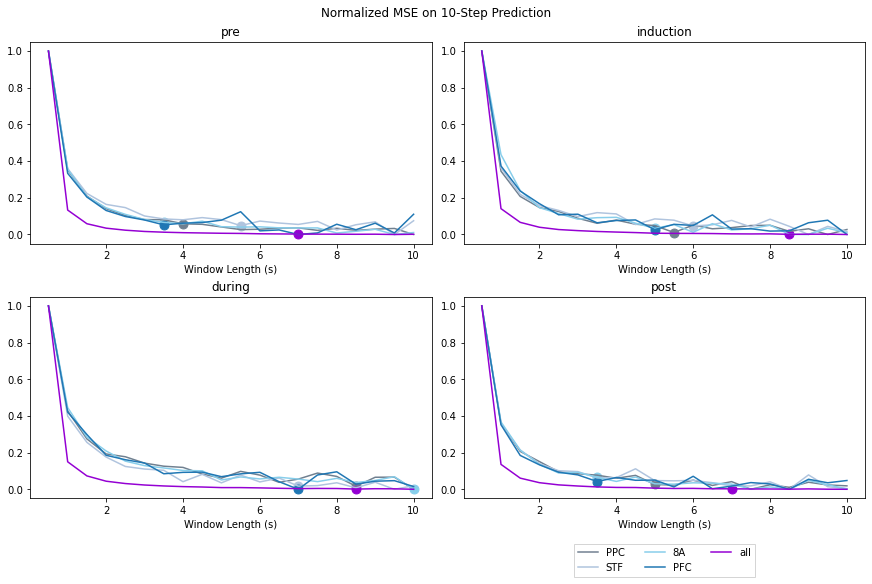

In [11]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 8))
window_sizes = np.arange(0.5, 10.1, 0.5)

# subfigs[0].set_facecolor('0.75')
# for ax in axsLeft:
#     pc = example_plot(ax)
# # subfigs[0].suptitle('Left plots', fontsize='x-large')
# subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')

for i, key in enumerate(['pre', 'induction', 'during', 'post']):
    ax = axs[int(i/2
                )][i%2]
    for area in window_selection_info['window_mses'][key].keys():
        vals = np.array(window_selection_info['window_mses'][key][area])
        vals = (vals - vals.min())/(vals.max() - vals.min())
        selected_window = window_selection_info['selected_windows'][key][area]
        selected_window_val = vals[window_sizes == selected_window]
        ax.plot(window_sizes, vals, label=area_labels[area], c=area_colors[area])
        ax.scatter(selected_window, selected_window_val, c=area_colors[area], s=80)
    ax.set_title(key)
    ax.set_xlabel('Window Length (s)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3)
plt.suptitle("Normalized MSE on 10-Step Prediction")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

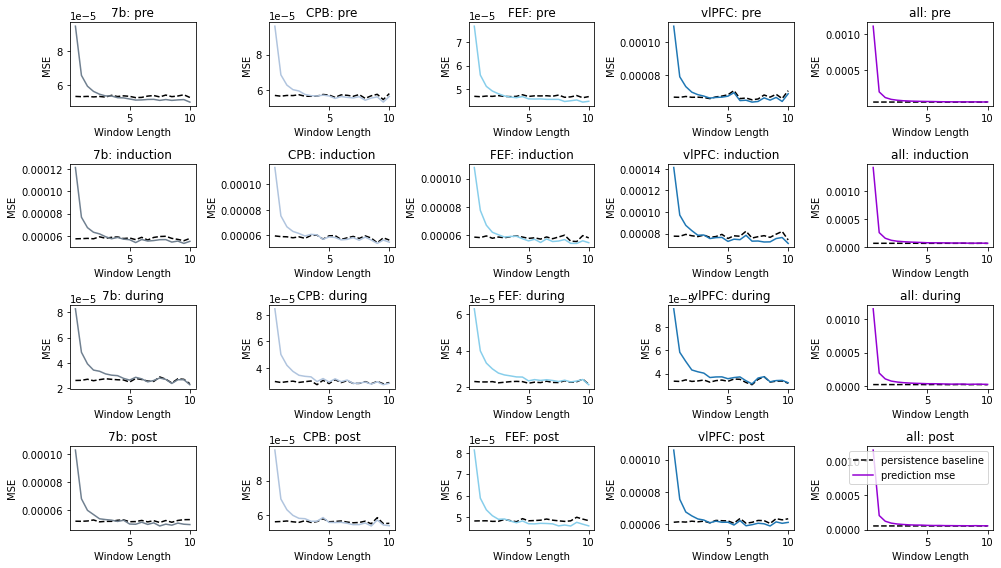

In [13]:
persistence_baseline = {}
iterator = tqdm(total = len(VAR_results.keys())*len(window_selection_info['true_vals']['all'].keys()))
for area in VAR_results.keys():
    if area == 'all':
        area_indices = np.arange(len(electrode_info['area']))
    else:
        area_indices = np.where(electrode_info['area'] == area)[0]
    persistence_baseline[area] = {}
    for window in window_selection_info['true_vals'][area].keys():
        persistence_baseline[area][window] = np.zeros(window_selection_info['step_mse'][area][window].shape)
        for i in range(persistence_baseline[area][window].shape[0]):
#             xt_plus_1= lfp[(i+1)*int(window/dt) + 1:(i+1)*int(window/dt) + persistence_baseline[area][window].shape[1] + 1, area_indices]
            xt = lfp[(i+1)*int(window/dt):(i+1)*int(window/dt) + persistence_baseline[area][window].shape[1], area_indices]
            xt_minus_1 = lfp[(i+1)*int(window/dt) - 1:(i+1)*int(window/dt) + persistence_baseline[area][window].shape[1] - 1, area_indices]
            persistence_baseline[area][window][i] = ((xt - xt_minus_1)**2).mean(axis=1)
        
        iterator.update()
iterator.close()

eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
        
slice_funcs = dict(
    pre=lambda window: slice(0, int(session_info['drugStart'][0]/window)),
    induction=lambda window: slice(int(session_info['drugStart'][0]/window), int(eyes_close/window)),
    during=lambda window: slice(int(eyes_close/window), int(session_info['drugEnd'][1]/window)),
    post=lambda window: slice(int(session_info['drugEnd'][1]/window),-1)
)

area_colors = {'vlPFC': 'C0', 'FEF': 'skyblue', '7b': 'slategray', 'CPB': 
               'lightsteelblue', 'all': 'darkviolet'}

fig, axs = plt.subplots(4, 5, figsize=(14, 8))

for i, key in enumerate(['pre', 'induction', 'during', 'post']):
    for j, area in enumerate(persistence_baseline.keys()):
        ax = axs[int((i*5 + j)/5)][(i*5 + j) % 5]
        pbs = []
        mses = []
        windows = np.arange(1, 21)*0.5
        for window in persistence_baseline[area].keys():
            pbs.append(persistence_baseline[area][window].mean(axis=1)[slice_funcs[key](window)].mean())
            mses.append(window_selection_info['step_mse'][area][window].mean(axis=1)[slice_funcs[key](window)].mean())
        ax.plot(windows[0:], pbs[0:], label='persistence baseline', c='k', linestyle='--')
        ax.plot(windows[0:], mses[0:], label='prediction mse', c=area_colors[area])
        ax.set_xlabel('Window Length')
        ax.set_ylabel('MSE')
        ax.set_title(f'{area}: {key}')
ax.legend()
plt.tight_layout()
plt.show()